In [1]:
from pathlib import Path
import sys

ROOT = next((p for p in [Path.cwd(), *Path.cwd().parents] if (p / "scripts").is_dir() or (p / "data").is_dir()), None)
if ROOT is None:
    raise RuntimeError("Repo-Root not found (expected folder 'scripts' or 'data').")
sys.path.insert(0, str(ROOT))

DATA_DIR = ROOT / "data"


In [2]:

import pandas as pd
import plotly.io as pio
pio.renderers.default = "vscode"

#local imports
from scripts.wp1.wp1_functions import save_subsets_as_tsv, split_all_data_into_subsets
from scripts.wp0.chem_graph_handling import visualize_graph
from scripts.vis_utils import visualize_reaction


## Loading the Dataset

This cell loads the cleaned reaction dataset from a TSV file into a pandas DataFrame and prints a small preview to verify that the data was read correctly.

In [3]:
dataset = DATA_DIR / "schneider50k_clean.tsv"
data = pd.read_csv(dataset, sep="\t") 
print("Data Overview:")
print(data.head())


Data Overview:
   Unnamed: 0.1  Unnamed: 0  \
0             0           0   
1             1           1   
2             2           2   
3             3           3   
4             4           4   

                                        original_rxn rxn_class      source  \
0  [CH3:17][S:14](=[O:15])(=[O:16])[N:11]1[CH2:10...     6.1.5  US06887874   
1  O.O.[Na+].[CH3:1][c:2]1[cH:7][c:6]([N+:8](=O)[...     7.1.1  US07056926   
2  [CH3:1][O:2][c:3]1[cH:4][cH:5][c:6](-[c:9]2[cH...     1.8.5  US08492378   
3  Cl.[CH3:43][CH2:42][S:44](=[O:45])(=[O:46])Cl....     2.2.3  US08592454   
4  [CH3:25][O:24][c:21]1[cH:22][cH:23][c:17]([O:1...     1.3.7  US06716851   

                                           clean_rxn  
0  [CH3:17][S:14](=[O:15])(=[O:16])[N:11]1[CH2:10...  
1  [CH3:1][c:2]1[cH:7][c:6]([N+:8](=O)[O-])[cH:5]...  
2  [CH3:1][O:2][c:3]1[cH:4][cH:5][c:6](-[c:9]2[cH...  
3  [CH3:43][CH2:42][S:44](=[O:45])(=[O:46])Cl.[CH...  
4  [CH3:25][O:24][c:21]1[cH:22][cH:23][c:17]([O:1...  

In [4]:
print("\nAnalysis of reaction classes:")
class_counts = data["rxn_class"].value_counts()
print(f"Number of classes: {len(class_counts)}")
print("Examples per class:")
print(class_counts)


Analysis of reaction classes:
Number of classes: 50
Examples per class:
rxn_class
6.1.5     1000
7.1.1     1000
1.8.5     1000
2.2.3     1000
1.3.7     1000
1.7.9     1000
6.2.2     1000
2.7.2     1000
2.6.1     1000
1.6.8     1000
3.1.1     1000
1.6.2     1000
1.2.1     1000
1.6.4     1000
1.2.5     1000
2.3.1     1000
5.1.1     1000
10.1.1    1000
2.1.1     1000
2.6.3     1000
6.2.1     1000
10.2.1    1000
1.2.4     1000
2.1.2     1000
6.3.7     1000
6.1.1     1000
9.3.1     1000
1.3.8     1000
1.3.6     1000
3.1.5     1000
6.2.3     1000
3.4.1     1000
6.1.3     1000
1.7.6     1000
10.1.2    1000
9.1.6     1000
10.1.5    1000
3.3.1     1000
10.4.2    1000
6.3.1     1000
1.7.7     1000
7.9.2     1000
8.1.5     1000
1.7.4     1000
7.2.1     1000
8.1.4     1000
8.2.1     1000
7.3.1     1000
2.1.7     1000
3.1.6     1000
Name: count, dtype: int64


## WP1 – Creating Class-Balanced Subsets

This cell splits the full dataset into small, class-balanced subsets.  
Each subset contains a fixed number of reaction classes and an equal number of reactions per class, which is required for WP1 experiments and manual inspection.

In [5]:
results = split_all_data_into_subsets(
    data,
    label_col="rxn_class", 
    min_classes=3,
    max_classes=3,
    min_n=20,
    max_n=20,
    seed=42,            
)

# Short overview
for i, (_, labels, counts) in enumerate(results, start=1):
    print(f"Subset {i}: Classes={labels}, Counts={counts}")

# Save
paths = save_subsets_as_tsv(results, out_dir= DATA_DIR / "subsets_small", prefix="subset")
print("Saved:", [str(p) for p in paths])

Subset 1: Classes=['1.7.4', '3.4.1', '7.9.2'], Counts={'7.9.2': 20, '1.7.4': 20, '3.4.1': 20}
Subset 2: Classes=['1.8.5', '3.1.6', '6.1.5'], Counts={'6.1.5': 20, '1.8.5': 20, '3.1.6': 20}
Subset 3: Classes=['2.1.1', '2.1.7', '6.3.7'], Counts={'6.3.7': 20, '2.1.1': 20, '2.1.7': 20}
Subset 4: Classes=['1.3.6', '2.1.1', '6.3.7'], Counts={'6.3.7': 20, '1.3.6': 20, '2.1.1': 20}
Subset 5: Classes=['1.7.6', '10.2.1', '7.1.1'], Counts={'1.7.6': 20, '7.1.1': 20, '10.2.1': 20}
Subset 6: Classes=['1.2.5', '1.7.9', '10.2.1'], Counts={'10.2.1': 20, '1.7.9': 20, '1.2.5': 20}
Subset 7: Classes=['1.2.4', '1.7.6', '2.6.1'], Counts={'1.2.4': 20, '2.6.1': 20, '1.7.6': 20}
Subset 8: Classes=['1.3.8', '2.6.1', '9.3.1'], Counts={'2.6.1': 20, '1.3.8': 20, '9.3.1': 20}
Subset 9: Classes=['1.6.8', '2.6.3', '8.2.1'], Counts={'8.2.1': 20, '1.6.8': 20, '2.6.3': 20}
Subset 10: Classes=['3.4.1', '6.3.7', '7.9.2'], Counts={'3.4.1': 20, '6.3.7': 20, '7.9.2': 20}
Subset 11: Classes=['2.6.1', '6.2.2', '8.1.4'], Counts=

## Example: Visualizing a Single Reaction as an ITS Graph

This cell visualizes one selected reaction as an ITS graph, representing the entire reaction in a single graph and highlighting the bond changes between reactants and products.

Eductgraph
16 {'element': 'N', 'aromatic': False, 'hcount': 2, 'charge': 0, 'neighbors': ['C'], 'atom_map': 16}
15 {'element': 'C', 'aromatic': True, 'hcount': 0, 'charge': 0, 'neighbors': ['C', 'C', 'N'], 'atom_map': 15}
17 {'element': 'C', 'aromatic': True, 'hcount': 1, 'charge': 0, 'neighbors': ['C', 'C'], 'atom_map': 17}
18 {'element': 'C', 'aromatic': True, 'hcount': 1, 'charge': 0, 'neighbors': ['C', 'C'], 'atom_map': 18}
12 {'element': 'C', 'aromatic': True, 'hcount': 0, 'charge': 0, 'neighbors': ['C', 'C', 'F'], 'atom_map': 12}
11 {'element': 'F', 'aromatic': False, 'hcount': 0, 'charge': 0, 'neighbors': ['C'], 'atom_map': 11}
13 {'element': 'C', 'aromatic': True, 'hcount': 0, 'charge': 0, 'neighbors': ['C', 'C', 'C'], 'atom_map': 13}
19 {'element': 'C', 'aromatic': False, 'hcount': 0, 'charge': 0, 'neighbors': ['C', 'F', 'F', 'F'], 'atom_map': 19}
20 {'element': 'F', 'aromatic': False, 'hcount': 0, 'charge': 0, 'neighbors': ['C'], 'atom_map': 20}
21 {'element': 'F', 'aromatic'

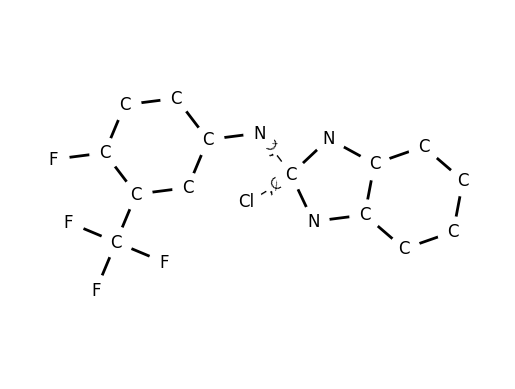

In [6]:
rmsi = data["clean_rxn"].iloc[9]
visualize_graph(rmsi)

## WP1 – Manual Inspection of Reaction Graphs
As part of WP1, this cell visualizes reactants, products, and the ITS graph of selected reactions to manually verify correct graph construction.

Educts show the molecules before the reaction.  
Products show the molecules after the reaction.  
The ITS graph combines both and highlights what changes during the reaction.

Eductgraph
16 {'element': 'N', 'aromatic': False, 'hcount': 2, 'charge': 0, 'neighbors': ['C'], 'atom_map': 16}
15 {'element': 'C', 'aromatic': True, 'hcount': 0, 'charge': 0, 'neighbors': ['C', 'C', 'N'], 'atom_map': 15}
17 {'element': 'C', 'aromatic': True, 'hcount': 1, 'charge': 0, 'neighbors': ['C', 'C'], 'atom_map': 17}
18 {'element': 'C', 'aromatic': True, 'hcount': 1, 'charge': 0, 'neighbors': ['C', 'C'], 'atom_map': 18}
12 {'element': 'C', 'aromatic': True, 'hcount': 0, 'charge': 0, 'neighbors': ['C', 'C', 'F'], 'atom_map': 12}
11 {'element': 'F', 'aromatic': False, 'hcount': 0, 'charge': 0, 'neighbors': ['C'], 'atom_map': 11}
13 {'element': 'C', 'aromatic': True, 'hcount': 0, 'charge': 0, 'neighbors': ['C', 'C', 'C'], 'atom_map': 13}
19 {'element': 'C', 'aromatic': False, 'hcount': 0, 'charge': 0, 'neighbors': ['C', 'F', 'F', 'F'], 'atom_map': 19}
20 {'element': 'F', 'aromatic': False, 'hcount': 0, 'charge': 0, 'neighbors': ['C'], 'atom_map': 20}
21 {'element': 'F', 'aromatic'

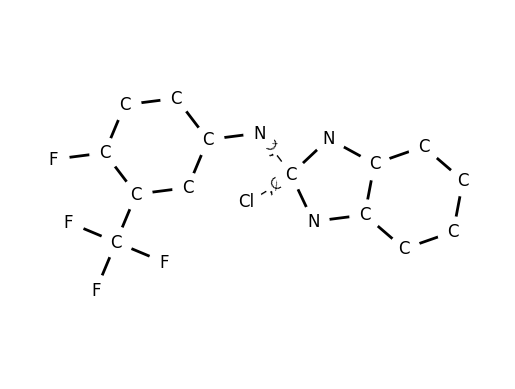

In [7]:

rmsi = data["clean_rxn"].iloc[9]

visualize_reaction(rmsi)                 # ITS (default)
visualize_reaction(rmsi, which="educt")   # Edukte
visualize_reaction(rmsi, which="product") # Produkte